# ALSO DOES NOT WORK

In [1]:
import sys
import os

current_dir = os.path.dirname(os.path.abspath(''))
others_path = os.path.join(current_dir, '..', 'gpr')

others_path = os.path.abspath(others_path)
if others_path not in sys.path:
    sys.path.append(others_path)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import eos
import kernels
import gaussianprocess
import finitedimensionalgp
import sampling as sam
import prepare_ceft as pc
import prepare_pqcd as pp
import anal_helpers as anal
from pqcd.pQCD import pQCD
from constants import get_phi, ns


from pathlib import Path
notebook_dir = Path.cwd()

from aquarel import load_theme
theme = (
        load_theme("gruvbox_dark")
        .set_font("serif")
        .set_grid(True, width=0.2)
        )

theme.apply()

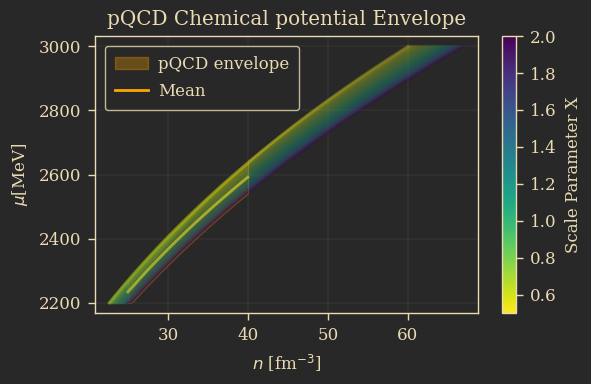

In [2]:
# 1. Set up the n grid and X samples
grid_size = 50
n_pqcd_grid = np.linspace(25, 40, grid_size) * ns   # fm⁻³
X_grid = np.geomspace(0.5, 2.0, 40)              # or use np.geomspace
mu_pqcd_grid = np.linspace(2.2,3,grid_size)*1000
# 2. Generate c_s² curves for each X
mu_family = []
for X in X_grid:
    n_raw, cs2_raw = pp.get_pqcd(X, size=grid_size)
    n_raw = n_raw * ns                        # convert to fm⁻³
    mu_interp = np.interp(n_pqcd_grid, n_raw, mu_pqcd_grid)
    mu_family.append(mu_interp)

mu_family = np.array(mu_family)               # shape: (n_X, n_n)
mu_min = mu_family.min(axis=0)
mu_max = mu_family.max(axis=0)
mu_mean = mu_family.mean(axis=0)

# 3. Plotting the envelope

plt.figure(figsize=(6, 4))
for mu in mu_family:
    plt.plot(n_pqcd_grid/ns, mu, lw=0.5, alpha=0.3, color='black')

plt.fill_between(n_pqcd_grid/ns, mu_min, mu_max, color='orange', alpha=0.3, label='pQCD envelope')
plt.plot(n_pqcd_grid/ns, mu_mean, color='orange', lw=2, label='Mean')
plt.xlabel(r'$n$ [fm$^{-3}$]')
plt.ylabel(r'$\mu$[MeV]')
plt.title('pQCD Chemical potential Envelope')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Plotting the pQCD curves for different X values
mu_grid = np.linspace(2.2, 3, grid_size)

pQCD1 = pQCD(1/2)  
pQCD2 = pQCD(2)    
array = np.geomspace(1/2, 2, grid_size)

norm = mcolors.Normalize(vmin=array.min(), vmax=array.max())
colormap = cm.viridis_r
for i in array:
    pQCDx = pQCD(i)
    color = colormap(norm(i)) 
    plt.plot(np.vectorize(pQCDx.number_density)(mu_grid)/ns, 
             mu_grid*1000, 
             color=color, alpha=0.1,
             linewidth=2)


sm = cm.ScalarMappable(cmap=colormap, norm=norm)
sm.set_array(array)  
cbar = plt.colorbar(sm, ax=plt.gca()) 
cbar.set_label('Scale Parameter X')

plt.show()


In [3]:
e_ini, p_ini, n_ini, mu_ini = anal.get_ceft_ini()


n_ceft, cs2_ceft, cs2_l, cs2_u = anal.get_ceft_cs2()
cs2_ceft_sigma = pc.CI_to_sigma(cs2_u-cs2_l)
cs2_hat, X_hat, sigma_hat, l_hat, alpha_hat = sam.get_hype_samples()
n_pqcd, cs2_pqcd = pp.get_pqcd(X_hat, size=200)
cs2_pqcd_sigma = np.ones_like(cs2_pqcd) * 1e-5



n = np.concatenate((n_ceft, n_pqcd))*ns
cs2 = np.concatenate((cs2_ceft, cs2_pqcd))
cs2_sigma = np.concatenate((cs2_ceft_sigma, cs2_pqcd_sigma))

In [4]:
m = 200 # somethings wrong with manually placing knots
kernel = kernels.Kernel('SE', sigma=sigma_hat, l=l_hat)
x_test = np.linspace(n_ceft[0], n_pqcd[-1], 400)*ns

fdgp = finitedimensionalgp.FDGP(kernel, n, cs2, x_test, cs2_sigma, cs2_hat, True, m=m, sampling=False, jitter_value=1e-8, normalise=False)

In [5]:
def integral_phi_j_num(knots, j, x_i, x0, x, nsamples: int = 1000):
    """
    Numerically evaluate
        ∫_{x0}^{x_i} φ_j(x) / x  dx
    where φ_j is the j-th triangular (hat) basis over the knot set `knots`.

    Parameters
    ----------
    knots : 1-D ndarray
        Knot positions **in the same physical units as x_i, x0, x**.
    j     : int
        Index of the hat basis (0 ≤ j < len(knots)).
    x_i   : float
        Integration upper limit (physical units).
    x0    : float
        Integration lower limit   (physical units).
    x     : 1-D ndarray
        The original training x-array – used only to reproduce the *same*
        0-to-1 normalisation that FDGP uses internally.
    nsamples : int, optional
        Number of trapezoid panels to use (default 1000;  100–200 already
        gives ∼ 1 e-6 accuracy).

    Returns
    -------
    float
        Numerical value of the integral.
    """
    # --- 0 → 1 normalisation identical to FDGP ----------------------------
    beta  = np.min(x)
    alpha = np.max(x) - beta

    # physical integration grid  (ascending order even if x_i < x0)
    xi_grid = np.linspace(x0, x_i, nsamples + 1)

    # φ_j evaluated in PHYSICAL x  ----------------------------------------
    def phi_j_physical(x_val: float) -> float:
        u = (x_val - beta) / alpha          # normalised coordinate 0 … 1
        t_j   = knots[j]
        t_jm1 = knots[j-1] if j > 0         else None
        t_jp1 = knots[j+1] if j < len(knots)-1 else None

        # Rising edge (skip for j=0)
        if t_jm1 is not None and t_jm1 <= u <= t_j:
            denom = t_j - t_jm1
            if denom == 0 or np.isinf(denom) or np.isnan(denom):
                print(f"[DEBUG] Division issue at j={j}, t_j={t_j}, t_jm1={t_jm1}, t_jp1={t_jp1}, u={u}, denom={denom}")
                return 0.0
            return (u - t_jm1) / denom
        # Falling edge (skip for j=last)
        elif t_jp1 is not None and t_j <= u <= t_jp1:
            denom = t_jp1 - t_j
            if denom == 0 or np.isinf(denom) or np.isnan(denom):
                print(f"[DEBUG] Division issue at j={j}, t_j={t_j}, t_jm1={t_jm1}, t_jp1={t_jp1}, u={u}, denom={denom}")
                return 0.0
            return (t_jp1 - u) / denom
        else:
            return 0.0

    # vectorise for speed
    phi_vals = np.fromiter((phi_j_physical(xx) for xx in xi_grid),
                           dtype=float, count=xi_grid.size)

    # trapezoidal ∫ φ_j(x) / x  dx
    integrand = phi_vals / xi_grid
    return np.trapz(integrand, xi_grid)


In [6]:
grid_size = 50
n_pqcd_grid_int = np.linspace(n_pqcd[0], n_pqcd[-1], grid_size) * ns   # fm⁻³

mu_pqcd_grid = np.linspace(2.2,3,grid_size)*1000
n_raw, cs2_raw = pp.get_pqcd(X_hat, size=grid_size)
n_raw = n_raw * ns                        # convert to fm⁻³
mu_interp = np.interp(n_pqcd_grid_int, n_raw, mu_pqcd_grid)

pqcd_int_obs = np.log(mu_interp/mu_ini)
pqcd_var_obs = np.ones_like(pqcd_int_obs) * 1e-2

In [7]:
#n_int = np.array([n_pqcd[0], n_pqcd[-1]]) * ns

#int_obs = np.array([pqcd_int_obs[0], pqcd_int_obs[-1]])
#int_sigma = np.array([pqcd_var_obs[0], pqcd_var_obs[-1]])

n_int = n_pqcd_grid_int
int_obs = pqcd_int_obs
int_sigma = pqcd_var_obs

Phi_int = np.array([
    [ integral_phi_j_num(
          knots=fdgp.knots,
          j=j,
          x_i=x_i,
          x0=n_ini,
          x=n
      )
      for j in fdgp.js ]
    for x_i in n_int
])

fdgp.add_linear_observations(Phi_int, int_obs, int_sigma)

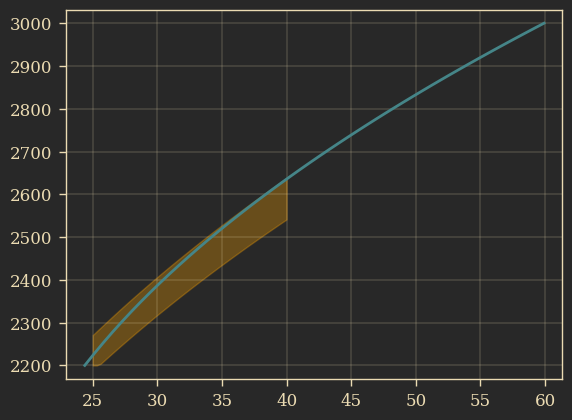

In [8]:
plt.plot(n_pqcd_grid_int/ns, mu_interp, label = "integral observation")

plt.fill_between(n_pqcd_grid/ns, mu_min, mu_max, color='orange', alpha=0.3, label='pQCD envelope')

plt.show()

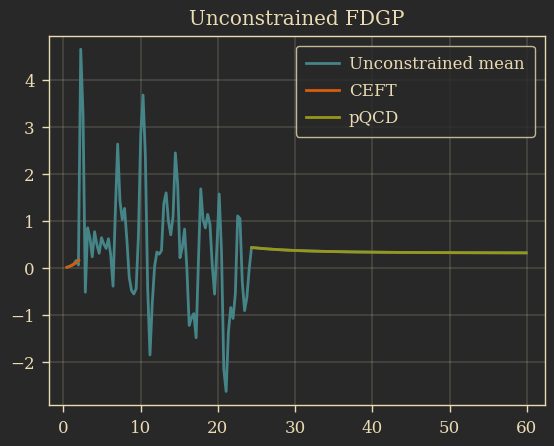

In [9]:
#### MAIN CELL #####

fdgp.fit()
knot_test_fdgp = (fdgp.knots)

cs2_test_fdgp = fdgp.mean_star
sig_fdgp = np.sqrt(np.diag(fdgp.cov_star))

plt.rcParams["font.family"] = "serif"

rng = np.random.default_rng()
y = rng.multivariate_normal(mean=fdgp.mean_star, cov=fdgp.cov_star)
plt.plot(knot_test_fdgp/ns, y, label='Unconstrained mean')
plt.plot(n_ceft, cs2_ceft, label = "CEFT")
plt.plot(n_pqcd, cs2_pqcd, label = "pQCD")
plt.legend()
plt.title('Unconstrained FDGP')
plt.show()

In [10]:
constr = fdgp.set_constraints(constraint_type='boundedness', m = fdgp.m, l = 0, u=1, rm_inf=True)

import cvxpy as cp
from scipy.linalg import cholesky, cho_solve


# Cholesky for efficient inverse
L = cholesky(fdgp.cov_star + 1e-8 * np.eye(fdgp.m), lower=True, check_finite=False)
Gamma_inv = cho_solve((L, True), np.eye(fdgp.m), check_finite=False)
r = Gamma_inv @ fdgp.mean_star
fdgp.cov_star_inverse=Gamma_inv
Q = Gamma_inv
c = -r
M = fdgp.constraints["M"]
g = fdgp.constraints["g"]

x = cp.Variable(fdgp.m)
objective = 0.5 * cp.quad_form(x, cp.psd_wrap(Q)) + c @ x
constraints = [M @ x + g >= 0]
problem = cp.Problem(cp.Minimize(objective), constraints)

# Solve the QP
problem.solve(solver=cp.PROXQP, verbose=True)

# Check status
if problem.status not in ["optimal", "optimal_inaccurate"]:
    raise RuntimeError(f"CVXPY failed: {problem.status}")

# Store the MAP
fdgp.map = x.value
xi_map = fdgp.map

(CVXPY) Aug 20 10:25:51 AM: Your problem has 200 variables, 400 constraints, and 0 parameters.
(CVXPY) Aug 20 10:25:51 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 20 10:25:51 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 20 10:25:51 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 20 10:25:51 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Aug 20 10:25:51 AM: Compiling problem (target solver=PROXQP).
(CVXPY) Aug 20 10:25:51 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> PROXQP
(CVXPY) Aug 20 10:25:51 AM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 20 10:25:51 AM: Applying reduction Qp2SymbolicQp
(CVXPY) Aug 20 10:25:51 AM: Applying reduction QpMatrixStuffing
(CVXPY) Aug 20 10:25:51 AM: Applying reduction PROXQP
(CVXPY) Aug 20 10:25:51 AM: Finished problem compil

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------

                              ProxQP - Primal-Dual Proximal QP Solver
     (c) Antoine Bambade, Sarah El Kazdadi, Fabian Schramm, Adrien Taylor, and Justin Carpentier
                                         Inria Paris 2022        

---------------------------

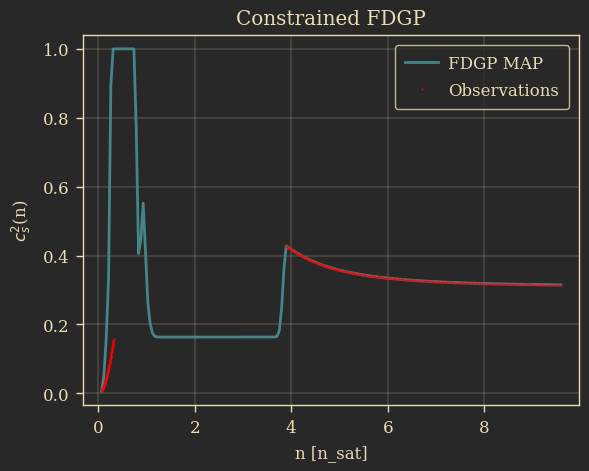

In [11]:
plt.plot(knot_test_fdgp, fdgp.map, label='FDGP MAP')
plt.plot(n, cs2, 'r.', markersize=1, label='Observations')
plt.xlabel('n [n_sat]')
plt.ylabel(r'$c_s^2$(n)')
plt.title("Constrained FDGP")
plt.legend()
plt.show()

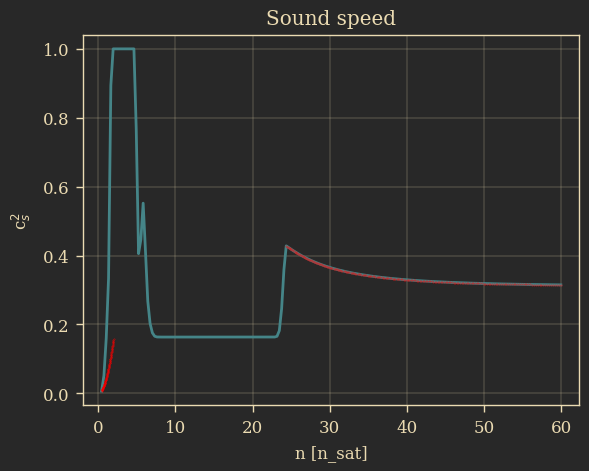

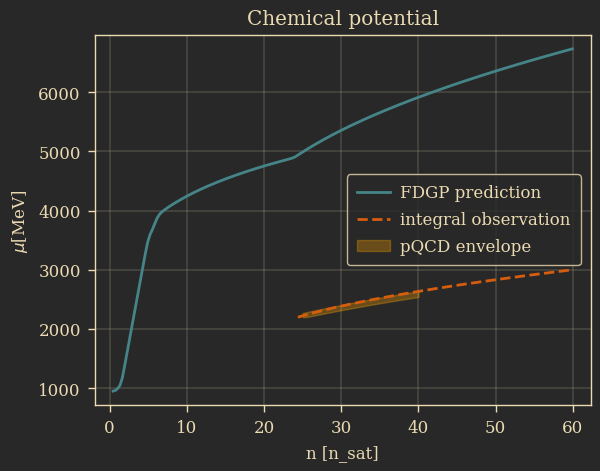

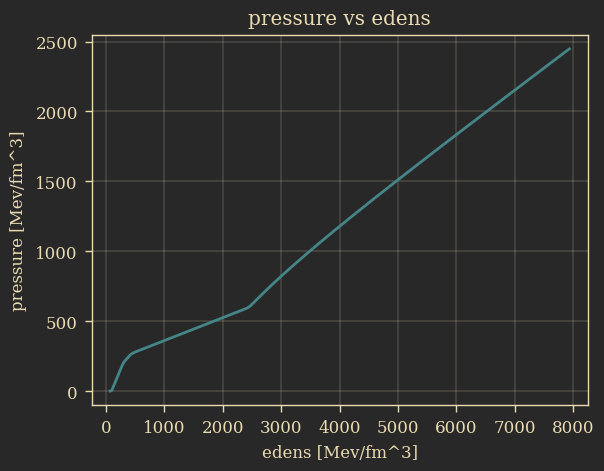

In [12]:
x_test_ns = x_test/ns

EOS = eos.EosProperties(fdgp.knots, phi=None, epsi_0 = e_ini, p_0 = p_ini, mu_0=mu_ini,  cs2=xi_map)
eos_prop_results = EOS.get_all()


plt.plot(fdgp.knots/ns, eos_prop_results['cs2'].flatten())
plt.plot(n/ns, cs2, 'r.', markersize=0.5, label='Observations')

plt.xlabel('n [n_sat]')
plt.ylabel(r'c$_s^2$')
plt.title(f"Sound speed")
plt.show()

plt.plot(fdgp.knots/ns, eos_prop_results["mu"].flatten(), label = "FDGP prediction")
plt.plot(n_pqcd_grid_int/ns, mu_interp, "--", label = "integral observation")
plt.fill_between(n_pqcd_grid/ns, mu_min, mu_max, color='orange', alpha=0.3, label='pQCD envelope')


plt.title("Chemical potential")
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\mu$[MeV]')
plt.legend()

#plt.xlim(0,5)
#plt.ylim(900,1300)

plt.show()

plt.plot(eos_prop_results["epsilon"].flatten(), eos_prop_results["pressure"].flatten())
plt.xlabel(r"edens [Mev/fm^3]")
plt.ylabel(r'pressure [Mev/fm^3]')
plt.title("pressure vs edens")
plt.show()

## using pqcd as lin ineq

In [ ]:
n_grid = n_pqcd_grid * ns
phi_values = np.zeros((m, len(n_grid)))

knots = fdgp.knots
for j in range(m):
    t_j = knots[j]
    t_j_m = knots[j-1] if j > 0 else None
    t_j_p = knots[j+1] if j < m-1 else None

    for i, x in enumerate(n_grid):
        if t_j_m is not None and t_j_m <= x <= t_j:
            abs_val = abs((x - t_j) / (t_j - t_j_m))
        elif t_j_p is not None and t_j <= x <= t_j_p:
            abs_val = abs((x - t_j) / (t_j_p - t_j))
        else:
            abs_val = np.inf

        phi_values[j, i] = max(0.0, 1 - abs_val)

# divide by n once (broadcasts along rows)
phi_over_n = phi_values / n_grid[None, :]  # broadcast over rows

# cumulative trapezoidal integrals along the grid axis
# (so ind_int[j, k] = ∫_{n0}^{n_grid[k]} φ_j(n)/n dn)
from scipy.integrate import cumulative_trapezoid as cumtrapz
indef_integrals = cumtrapz(phi_over_n, x=n_grid, axis=1, initial=0.0)
idxs = np.searchsorted(n_grid, n_pqcd_grid*ns)
Lam_int = indef_integrals[:, idxs].T

Lam_int = np.array([Lam_int[1],Lam_int[-1]]) # 0th row is for some reason all zeroes? look into this TODO

l_int = np.log(mu_min/mu_ini)
u_int = np.log(mu_max/mu_ini)
l_int = np.array([l_int[1], l_int[-1]])
u_int = np.array([u_int[1], u_int[-1]])
int_constraints = fdgp.set_constraints(constraint_type="linear", A=Lam_int, l=l_int, u=u_int)


In [59]:
bounded_constraints = fdgp.set_constraints(constraint_type="boundedness", m=fdgp.m, l=0, u=1, rm_inf=True)
fdgp.combine_constraints(bounded_constraints, int_constraints)

In [60]:
import cvxpy as cp
from scipy.linalg import cholesky, cho_solve


# Cholesky for efficient inverse
L = cholesky(fdgp.cov_star + 1e-8 * np.eye(fdgp.m), lower=True, check_finite=False)
Gamma_inv = cho_solve((L, True), np.eye(fdgp.m), check_finite=False)
r = Gamma_inv @ fdgp.mean_star
fdgp.cov_star_inverse=Gamma_inv
Q = Gamma_inv
c = -r
M = fdgp.constraints["M"]
g = fdgp.constraints["g"]

x = cp.Variable(fdgp.m)
objective = 0.5 * cp.quad_form(x, cp.psd_wrap(Q)) + c @ x
constraints = [M @ x + g >= 0]
problem = cp.Problem(cp.Minimize(objective), constraints)

# Solve the QP
problem.solve(solver=cp.PROXQP, verbose=True)

# Check status
if problem.status not in ["optimal", "optimal_inaccurate"]:
    raise RuntimeError(f"CVXPY failed: {problem.status}")

# Store the MAP
fdgp.map = x.value
xi_map = fdgp.map

(CVXPY) Aug 20 08:21:26 AM: Your problem has 200 variables, 404 constraints, and 0 parameters.
(CVXPY) Aug 20 08:21:26 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 20 08:21:26 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 20 08:21:26 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 20 08:21:26 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Aug 20 08:21:26 AM: Compiling problem (target solver=PROXQP).
(CVXPY) Aug 20 08:21:26 AM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing -> PROXQP
(CVXPY) Aug 20 08:21:26 AM: Applying reduction CvxAttr2Constr
(CVXPY) Aug 20 08:21:26 AM: Applying reduction Qp2SymbolicQp
(CVXPY) Aug 20 08:21:26 AM: Applying reduction QpMatrixStuffing
(CVXPY) Aug 20 08:21:26 AM: Applying reduction PROXQP
(CVXPY) Aug 20 08:21:26 AM: Finished problem compil

                                     CVXPY                                     
                                     v1.6.6                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------


                     

RuntimeError: CVXPY failed: infeasible

In [68]:
from scipy.linalg import cholesky, cho_solve
from scipy.optimize import minimize

# Cholesky for efficient inverse
L = cholesky(fdgp.cov_star + 1e-8 * np.eye(fdgp.m), lower=True, check_finite=False)
Gamma_inv = cho_solve((L, True), np.eye(fdgp.m), check_finite=False)
r = Gamma_inv @ fdgp.mean_star
fdgp.cov_star_inverse = Gamma_inv
Q = Gamma_inv
c = -r
M = fdgp.constraints["M"]
g = fdgp.constraints["g"]

def qp_objective(x):
    # 0.5 * x^T Q x + c^T x
    return 0.5 * np.dot(x, Q @ x) + np.dot(c, x)

def qp_jac(x):
    # Gradient: Qx + c
    return Q @ x + c

# SLSQP constraints: Mx + g >= 0  -->  Mx + g >= 0
ineq_constraints = []
for i in range(M.shape[0]):
    def constr_factory(M_row, g_val):
        return lambda x, M_row=M_row, g_val=g_val: np.dot(M_row, x) + g_val
    ineq_constraints.append({'type': 'ineq', 'fun': constr_factory(M[i], g[i])})

x0 = np.zeros(fdgp.m)  # Initial guess

result = minimize(qp_objective, x0, jac=qp_jac, constraints=ineq_constraints, method='SLSQP', options={'disp': True, 'maxiter': 1000})

if not result.success:
    raise RuntimeError(f"SLSQP failed: {result.message}")

fdgp.map = result.x
xi_map = fdgp.map

Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -384239913.74875677
            Iterations: 7
            Function evaluations: 18
            Gradient evaluations: 3


RuntimeError: SLSQP failed: Positive directional derivative for linesearch

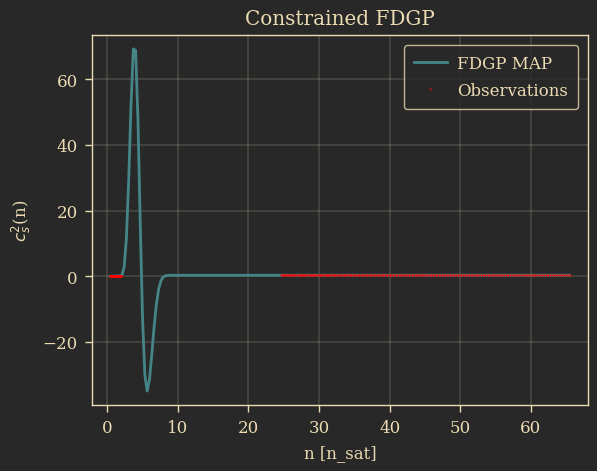

In [58]:
plt.plot(knot_test_fdgp/ns, fdgp.map, label='FDGP MAP')
plt.plot(n/ns, cs2, 'r.', markersize=1, label='Observations')
plt.xlabel('n [n_sat]')
plt.ylabel(r'$c_s^2$(n)')
plt.title("Constrained FDGP")
plt.legend()
plt.show()

In [ ]:
x_test_ns = x_test/ns

EOS = eos.EosProperties(x_test_ns, phi=None, epsi_0 = e_ini, p_0 = p_ini, mu_0=mu_ini,  cs2=xi_map)
eos_prop_results = EOS.get_all()


plt.plot(x_test_ns, eos_prop_results['cs2'].flatten())
plt.plot(n/ns, cs2, 'r.', markersize=0.5, label='Observations')

plt.xlabel('n [n_sat]')
plt.ylabel(r'c$_s^2$')
plt.title(f"Sound speed")
plt.show()

plt.plot(x_test_ns, eos_prop_results["mu"].flatten(), label = "FDGP prediction")
plt.plot(n_pqcd_int/0.16, mu_pqcd, "--", label = "integral observation")
plt.plot(n_ceft_int, mu_ceft_avg, label = "ceft")
plt.plot(n_ceft_int, mu_ceft_upper, color = 'pink', alpha=0.5)
plt.plot(n_ceft_int, mu_ceft_lower, color = 'pink', alpha=0.5)


plt.title("Chemical potential")
plt.xlabel('n [n_sat]')
plt.ylabel(r'$\mu$[MeV]')
plt.legend()

#plt.xlim(0,5)
#plt.ylim(900,1300)

plt.show()

plt.plot(eos_prop_results["epsilon"].flatten(), eos_prop_results["pressure"].flatten())
plt.xlabel(r"edens [Mev/fm^3]")
plt.ylabel(r'pressure [Mev/fm^3]')
plt.title("pressure vs edens")
plt.show()